# Exploring Contextural Bias of ResNet50 on CIFAR10 Dataset - Stylised ResNet50 Torch

### Introduction

This notebook trains and tests a stylised ResNet50 torch model with the CIFAR10 dataset. It includes functions for loading the dataset, turning them into tensors, model training and testing.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Conv2d, AvgPool2d
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from skimage import io
import numpy as np
from PIL import Image

### Data Loading

The following cell provides a class that loads the CIFAR dataset given the relevant path, processes it into a dictionary format of class labels and content then processes the images into tensors. The class also has helper functions to extract information about the dataset needed for model training and testing.

In [2]:
class CifarDataset(Dataset):
    
    def __init__(self, data_path):
        
        super(CifarDataset, self).__init__()
        self.data_path = data_path
        self.num_classes = 0
        self.classes = []
        
        classes_list = []
        for class_name in os.listdir(data_path):
            if not os.path.isdir(os.path.join(data_path,class_name)):
                continue
            classes_list.append(class_name)
        classes_list.sort()
        self.classes = [dict(class_idx = k, class_name = v) for k, v in enumerate(classes_list)]
        

        self.num_classes = len(self.classes)

        self.image_list = []
        for cls in self.classes:
            class_path = os.path.join(data_path, cls['class_name'])
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_list.append(dict(
                    cls = cls,
                    image_path = image_path,
                    image_name = image_name,
                ))

        self.img_idxes = np.arange(0,len(self.image_list))

    def __len__(self):
        return len(self.img_idxes)

    def __getitem__(self, index):

        img_idx = self.img_idxes[index]
        img_info = self.image_list[img_idx]

        img = Image.open(img_info['image_path'])

        tr = transforms.ToTensor()
        img = tr(img)
        tr = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        img = tr(img)
        return dict(image = img, cls = img_info['cls']['class_idx'], class_name = img_info['cls']['class_name'])

    def get_number_of_classes(self):
        return self.num_classes

    def get_number_of_samples(self):
        return self.__len__()

    def get_class_names(self):
        return [cls['class_name'] for cls in self.classes]

    def get_class_name(self, class_idx):
        return self.classes[class_idx]['class_name']

In [3]:
def get_cifar_datasets(data_path):
    dataset = CifarDataset(data_path)
    return dataset

The data being used for this experiment are normal CIFAR10 dataset, stylised CIFAR10 dataset and stylised CIFAR10 dataset created by using reduced style images where stylisation was done by AdaIN style transfer.

The following cells call the function created above to load the training, validation and testing datasets of the normal, stylised and reduced stylised CIFAR10 datasets and transform them into data loaders.

In [4]:
# Load normal CIFAR10
data_path_train = "../../CIFAR/cifar32/training"
dataset_train = get_cifar_datasets(data_path_train)

data_path_val = "../../CIFAR/cifar32/validation/"
dataset_val = get_cifar_datasets(data_path_val)

data_path_test = "../../CIFAR/cifar32/testing/"
dataset_test = get_cifar_datasets(data_path_test)

print(f"Number of train samples {dataset_train.__len__()}")
print("Class names are: " + str(dataset_train.get_class_names()))

print(f"Number of val samples {dataset_val.__len__()}")
print("Class names are: " + str(dataset_val.get_class_names()))

print(f"Number of test samples {dataset_test.__len__()}")
print("Class names are: " + str(dataset_test.get_class_names()))

BATCH_SIZE = 64

data_loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True)
data_loader_val = DataLoader(dataset_val, BATCH_SIZE, shuffle = True)
data_loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = True)

Number of train samples 36000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of val samples 4000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of test samples 10000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']


In [5]:
# Load stylised CIFAR10 with original kaggle images
data_path_train_style = "../../CIFAR/cifar32_style/training"
dataset_train_style = get_cifar_datasets(data_path_train_style)

data_path_val_style = "../../CIFAR/cifar32_style/validation/"
dataset_val_style = get_cifar_datasets(data_path_val_style)

data_path_test_style = "../../CIFAR/cifar32_style/testing/"
dataset_test_style = get_cifar_datasets(data_path_test_style)

print(f"Number of stylised train samples {dataset_train_style.__len__()}")
print("Class names are: " + str(dataset_train_style.get_class_names()))

print(f"Number of stylised val samples {dataset_val_style.__len__()}")
print("Class names are: " + str(dataset_val_style.get_class_names()))

print(f"Number of stylised test samples {dataset_test_style.__len__()}")
print("Class names are: " + str(dataset_test_style.get_class_names()))

BATCH_SIZE = 64

data_loader_train_style = DataLoader(dataset_train_style, BATCH_SIZE, shuffle = True)
data_loader_val_style = DataLoader(dataset_val_style, BATCH_SIZE, shuffle = True)
data_loader_test_style = DataLoader(dataset_test_style, BATCH_SIZE, shuffle = True)

Number of stylised train samples 216000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of stylised val samples 4000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of stylised test samples 10000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']


In [6]:
# Load stylised CIFAR10 with reduced kaggle images
data_path_train_style_red = "../../CIFAR/cifar32_style_red/training"
dataset_train_style_red = get_cifar_datasets(data_path_train_style_red)

data_path_val_style_red = "../../CIFAR/cifar32_style_red/validation/"
dataset_val_style_red = get_cifar_datasets(data_path_val_style_red)

data_path_test_style_red = "../../CIFAR/cifar32_style_red/testing/"
dataset_test_style_red = get_cifar_datasets(data_path_test_style_red)

print(f"Number of reduced stylised train samples {dataset_train_style_red.__len__()}")
print("Class names are: " + str(dataset_train_style_red.get_class_names()))

print(f"Number of reduced stylised val samples {dataset_val_style_red.__len__()}")
print("Class names are: " + str(dataset_val_style_red.get_class_names()))

print(f"Number of reduced stylised test samples {dataset_test_style_red.__len__()}")
print("Class names are: " + str(dataset_test_style_red.get_class_names()))

BATCH_SIZE = 64

data_loader_train_style_red = DataLoader(dataset_train_style_red, BATCH_SIZE, shuffle = True)
data_loader_val_style_red = DataLoader(dataset_val_style_red, BATCH_SIZE, shuffle = True)
data_loader_test_style_red = DataLoader(dataset_test_style_red, BATCH_SIZE, shuffle = True)

Number of reduced stylised train samples 216000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of reduced stylised val samples 4000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of reduced stylised test samples 10000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Shape of batch['image'] torch.Size([64, 3, 32, 32])
Shape of batch['cls'] torch.Size([64])


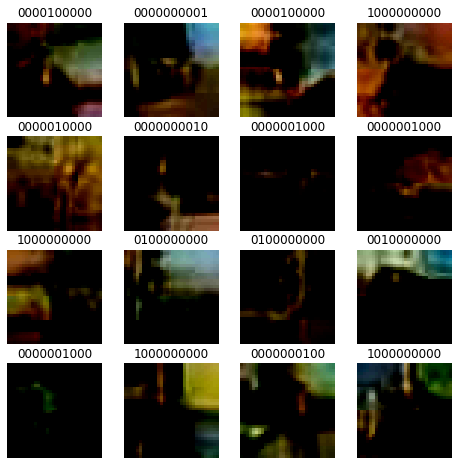

In [7]:
# Check if the data was loaded correctly
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4,4, figsize=(8, 8))

for batch in data_loader_test_style:

    print(f"Shape of batch['image'] {batch['image'].shape}")
    print(f"Shape of batch['cls'] {batch['cls'].shape}")

    for i in range(BATCH_SIZE):
        col = i % 4
        row = i // 4

        img = batch['image'][i].numpy()

        axes[row,col].set_axis_off()
        axes[row,col].set_title(batch['class_name'][i])
        axes[row,col].imshow(np.transpose(img,(1,2,0)))
                         
        if i >= 15:
            break

    plt.show()
    break

Following are the training, validation and testing functions for the experiment. train_part() function trains and updates gradients on each batch of the training set and once that is done, it tests its accuracy on the validation set. Every time the validation test returns a better accuracy than the current maximum, the model is saved and carries on with the next epoch. Then it checks with the learning reate scheduler for any changes in learning rate.

In [10]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
print(device)
    
print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for i, batch in enumerate(loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = batch['image'].to(device)
            labels = batch['cls'].to(device)
            scores = model(inputs)
            _, preds = scores.max(1)
            num_correct += (preds == labels).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct, accuracy of the dataset is: %.3f %%' % (num_correct, num_samples, 100 * acc))


def train_part(model, train_data, val_data, model_path, optimizer, lr_scheduler, epochs=1):
    model.to(device)
    val_acc = 0
    num_epoch = 2
    # Main Loop
    for epoch in range(epochs):  # loop over the dataset multiple times
        val_loss = 0
        running_loss = 0

        # Training Loop
        for i, batch in enumerate(train_data, 0):
            # set model to training mode
            model.train()
            # get the inputs; data is a list of [inputs, labels]
            inputs = batch['image'].to(device)
            labels = batch['cls'].to(device)

            # get outputs from the input data and calculate the cross entropy loss
            scores = model(inputs)
            loss = F.cross_entropy(scores, labels)

            # zero and update the gradients and optimise
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print('[%d, %5d] loss: %.6f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

        # set model to evaluation mode
        model.eval()

        # Validation Loop
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for i, batch in enumerate(val_data, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs = batch['image'].to(device)
                labels = batch['cls'].to(device)

                # get the outputs from the model
                outputs = model(inputs)

                # compute accuracy based on the outputs
                _, preds = outputs.max(1)
                num_correct += (preds == labels).sum()
                num_samples += preds.size(0)
            acc = float(num_correct) / num_samples
            print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

            if acc > val_acc:
                print('saving model')
                torch.save(model.state_dict(), model_path)
                val_acc = acc
            else:
                print('skip model saving')
        lr_scheduler.step()

cuda:5


### Stylised ResNet50 Training

The model used in this experiment is ResNet50 from torchvision library trained for 350 epochs with Adam optimiser, learning rate scheduler and default settings. The dataset used to train the model is stylised CIFAR10. Learning rate starts at 0.1 and changes every 150, 250th epoch.

In [12]:
torch.cuda.empty_cache()

# define and train the network
stylised_model_path_torch = './cifar32_style_torch.pth'
stylised_model_torch = torchvision.models.resnet50().to(device)
lr=0.1
stylised_optimizer_torch = optim.Adam(stylised_model_torch.parameters(), lr=lr)
stylised_lr_scheduler_torch = optim.lr_scheduler.MultiStepLR(stylised_optimizer_torch, milestones=[150, 250])
train_part(stylised_model_torch, data_loader_train_style, data_loader_val_style, stylised_model_path_torch, stylised_optimizer_torch, stylised_lr_scheduler_torch, epochs = 350)

[1,   200] loss: 4.814861
[1,   400] loss: 2.330386
[1,   600] loss: 2.325220
[1,   800] loss: 2.320634
[1,  1000] loss: 2.314374
[1,  1200] loss: 2.314757
[1,  1400] loss: 2.310814
[1,  1600] loss: 2.329358
[1,  1800] loss: 2.311765
[1,  2000] loss: 2.311805
[1,  2200] loss: 2.312730
[1,  2400] loss: 2.313262
[1,  2600] loss: 2.310711
[1,  2800] loss: 2.312876
[1,  3000] loss: 2.309694
[1,  3200] loss: 2.311206
Got 381 / 4000 correct (9.53)
saving model
[2,   200] loss: 2.310493
[2,   400] loss: 2.311781
[2,   600] loss: 2.311385
[2,   800] loss: 2.313027
[2,  1000] loss: 2.311976
[2,  1200] loss: 2.311547
[2,  1400] loss: 2.310302
[2,  1600] loss: 2.311423
[2,  1800] loss: 2.311325
[2,  2000] loss: 2.311794
[2,  2200] loss: 4.386050
[2,  2400] loss: 2.348172
[2,  2600] loss: 2.310305
[2,  2800] loss: 2.311673
[2,  3000] loss: 2.311817
[2,  3200] loss: 2.309990
Got 381 / 4000 correct (9.53)
skip model saving
[3,   200] loss: 2.312606
[3,   400] loss: 2.310862
[3,   600] loss: 2.311252

[18,  1600] loss: 2.311134
[18,  1800] loss: 2.309463
[18,  2000] loss: 2.310559
[18,  2200] loss: 2.312627
[18,  2400] loss: 2.312621
[18,  2600] loss: 2.311939
[18,  2800] loss: 2.310307
[18,  3000] loss: 2.312118
[18,  3200] loss: 2.310979
Got 381 / 4000 correct (9.53)
skip model saving
[19,   200] loss: 2.310983
[19,   400] loss: 2.313033
[19,   600] loss: 2.311456
[19,   800] loss: 2.311632
[19,  1000] loss: 2.312604
[19,  1200] loss: 2.309319
[19,  1400] loss: 2.309513
[19,  1600] loss: 2.311836
[19,  1800] loss: 2.313165
[19,  2000] loss: 2.311213
[19,  2200] loss: 2.311403
[19,  2400] loss: 2.312746
[19,  2600] loss: 2.310331
[19,  2800] loss: 2.311961
[19,  3000] loss: 2.312265
[19,  3200] loss: 2.310400
Got 396 / 4000 correct (9.90)
skip model saving
[20,   200] loss: 2.309914
[20,   400] loss: 2.311953
[20,   600] loss: 2.315150
[20,   800] loss: 2.313603
[20,  1000] loss: 2.313026
[20,  1200] loss: 2.313578
[20,  1400] loss: 2.312315
[20,  1600] loss: 2.312913
[20,  1800] l

[35,  2000] loss: 2.312904
[35,  2200] loss: 2.313250
[35,  2400] loss: 2.310845
[35,  2600] loss: 2.312410
[35,  2800] loss: 2.312473
[35,  3000] loss: 2.309167
[35,  3200] loss: 2.311417
Got 381 / 4000 correct (9.53)
skip model saving
[36,   200] loss: 2.310518
[36,   400] loss: 2.310985
[36,   600] loss: 2.309825
[36,   800] loss: 2.312776
[36,  1000] loss: 2.311838
[36,  1200] loss: 2.311513
[36,  1400] loss: 2.309991
[36,  1600] loss: 2.312109
[36,  1800] loss: 2.308711
[36,  2000] loss: 2.310723
[36,  2200] loss: 2.311954
[36,  2400] loss: 2.313037
[36,  2600] loss: 2.310198
[36,  2800] loss: 2.311495
[36,  3000] loss: 2.310723
[36,  3200] loss: 2.308546
Got 422 / 4000 correct (10.55)
skip model saving
[37,   200] loss: 2.312666
[37,   400] loss: 2.311650
[37,   600] loss: 2.311663
[37,   800] loss: 2.312645
[37,  1000] loss: 2.310951
[37,  1200] loss: 2.310392
[37,  1400] loss: 2.312809
[37,  1600] loss: 2.309977
[37,  1800] loss: 2.309551
[37,  2000] loss: 2.311298
[37,  2200] 

[52,  2200] loss: 2.313430
[52,  2400] loss: 2.312406
[52,  2600] loss: 2.312074
[52,  2800] loss: 2.311504
[52,  3000] loss: 2.311326
[52,  3200] loss: 2.312881
Got 383 / 4000 correct (9.57)
skip model saving
[53,   200] loss: 2.310500
[53,   400] loss: 2.311214
[53,   600] loss: 2.311482
[53,   800] loss: 2.310261
[53,  1000] loss: 2.310285
[53,  1200] loss: 2.310164
[53,  1400] loss: 2.311696
[53,  1600] loss: 2.311278
[53,  1800] loss: 2.310329
[53,  2000] loss: 2.312387
[53,  2200] loss: 2.309215
[53,  2400] loss: 2.311149
[53,  2600] loss: 2.311414
[53,  2800] loss: 2.311098
[53,  3000] loss: 2.311790
[53,  3200] loss: 2.313049
Got 381 / 4000 correct (9.53)
skip model saving
[54,   200] loss: 2.312472
[54,   400] loss: 2.313333
[54,   600] loss: 2.312274
[54,   800] loss: 2.310973
[54,  1000] loss: 2.310938
[54,  1200] loss: 2.310665
[54,  1400] loss: 2.310373
[54,  1600] loss: 2.310903
[54,  1800] loss: 2.312175
[54,  2000] loss: 2.311982
[54,  2200] loss: 2.309317
[54,  2400] l

[69,  2400] loss: 2.311424
[69,  2600] loss: 2.310697
[69,  2800] loss: 2.311557
[69,  3000] loss: 2.311577
[69,  3200] loss: 2.312351
Got 405 / 4000 correct (10.12)
skip model saving
[70,   200] loss: 2.312113
[70,   400] loss: 2.311466
[70,   600] loss: 2.310278
[70,   800] loss: 2.312297
[70,  1000] loss: 2.312065
[70,  1200] loss: 2.312499
[70,  1400] loss: 2.311278
[70,  1600] loss: 2.312684
[70,  1800] loss: 2.310257
[70,  2000] loss: 2.311331
[70,  2200] loss: 2.312441
[70,  2400] loss: 2.311067
[70,  2600] loss: 2.311384
[70,  2800] loss: 2.311586
[70,  3000] loss: 2.312489
[70,  3200] loss: 2.313166
Got 422 / 4000 correct (10.55)
skip model saving
[71,   200] loss: 2.311777
[71,   400] loss: 2.311305
[71,   600] loss: 2.309190
[71,   800] loss: 2.311067
[71,  1000] loss: 2.314080
[71,  1200] loss: 2.313217
[71,  1400] loss: 2.314880
[71,  1600] loss: 2.311985
[71,  1800] loss: 2.310070
[71,  2000] loss: 2.310055
[71,  2200] loss: 2.311458
[71,  2400] loss: 2.311414
[71,  2600]

[86,  2600] loss: 2.310996
[86,  2800] loss: 2.312543
[86,  3000] loss: 2.310612
[86,  3200] loss: 2.311645
Got 422 / 4000 correct (10.55)
skip model saving
[87,   200] loss: 2.312844
[87,   400] loss: 2.310613
[87,   600] loss: 2.312361
[87,   800] loss: 2.314859
[87,  1000] loss: 2.311684
[87,  1200] loss: 2.312574
[87,  1400] loss: 2.310529
[87,  1600] loss: 2.310686
[87,  1800] loss: 2.312262
[87,  2000] loss: 2.311329
[87,  2200] loss: 2.310695
[87,  2400] loss: 2.314100
[87,  2600] loss: 2.311577
[87,  2800] loss: 2.312209
[87,  3000] loss: 2.312026
[87,  3200] loss: 2.312240
Got 405 / 4000 correct (10.12)
skip model saving
[88,   200] loss: 2.309882
[88,   400] loss: 2.311690
[88,   600] loss: 2.313722
[88,   800] loss: 2.310530
[88,  1000] loss: 2.311665
[88,  1200] loss: 2.311346
[88,  1400] loss: 2.311075
[88,  1600] loss: 2.311024
[88,  1800] loss: 2.311204
[88,  2000] loss: 2.311687
[88,  2200] loss: 2.310669
[88,  2400] loss: 2.310756
[88,  2600] loss: 2.311480
[88,  2800]

[103,  2400] loss: 2.312629
[103,  2600] loss: 2.310237
[103,  2800] loss: 2.311601
[103,  3000] loss: 2.311324
[103,  3200] loss: 2.309444
Got 422 / 4000 correct (10.55)
skip model saving
[104,   200] loss: 2.311893
[104,   400] loss: 2.311682
[104,   600] loss: 2.312182
[104,   800] loss: 2.310641
[104,  1000] loss: 2.312689
[104,  1200] loss: 2.312724
[104,  1400] loss: 2.309080
[104,  1600] loss: 2.313481
[104,  1800] loss: 2.313145
[104,  2000] loss: 2.312971
[104,  2200] loss: 2.311139
[104,  2400] loss: 2.310586
[104,  2600] loss: 2.313201
[104,  2800] loss: 2.311226
[104,  3000] loss: 2.311724
[104,  3200] loss: 2.313551
Got 415 / 4000 correct (10.38)
skip model saving
[105,   200] loss: 2.312522
[105,   400] loss: 2.310305
[105,   600] loss: 2.312295
[105,   800] loss: 2.312836
[105,  1000] loss: 2.311431
[105,  1200] loss: 2.312090
[105,  1400] loss: 2.310292
[105,  1600] loss: 2.310914
[105,  1800] loss: 2.311645
[105,  2000] loss: 2.309536
[105,  2200] loss: 2.311990
[105, 

[120,   800] loss: 2.311413
[120,  1000] loss: 2.312220
[120,  1200] loss: 2.312268
[120,  1400] loss: 2.311085
[120,  1600] loss: 2.309850
[120,  1800] loss: 2.311735
[120,  2000] loss: 2.310835
[120,  2200] loss: 2.310422
[120,  2400] loss: 2.311717
[120,  2600] loss: 2.310853
[120,  2800] loss: 2.311171
[120,  3000] loss: 2.312420
[120,  3200] loss: 2.312994
Got 422 / 4000 correct (10.55)
skip model saving
[121,   200] loss: 2.310614
[121,   400] loss: 2.311397
[121,   600] loss: 2.311874
[121,   800] loss: 2.312253
[121,  1000] loss: 2.310890
[121,  1200] loss: 2.312440
[121,  1400] loss: 2.311346
[121,  1600] loss: 2.311909
[121,  1800] loss: 2.311342
[121,  2000] loss: 2.311919
[121,  2200] loss: 2.313043
[121,  2400] loss: 2.313490
[121,  2600] loss: 2.310276
[121,  2800] loss: 2.310202
[121,  3000] loss: 2.311127
[121,  3200] loss: 2.312370
Got 396 / 4000 correct (9.90)
skip model saving
[122,   200] loss: 2.312161
[122,   400] loss: 2.310650
[122,   600] loss: 2.309964
[122,  

[136,  2600] loss: 2.310713
[136,  2800] loss: 2.309886
[136,  3000] loss: 2.312325
[136,  3200] loss: 2.311509
Got 394 / 4000 correct (9.85)
skip model saving
[137,   200] loss: 2.312563
[137,   400] loss: 2.311981
[137,   600] loss: 2.309944
[137,   800] loss: 2.311968
[137,  1000] loss: 2.313840
[137,  1200] loss: 2.311864
[137,  1400] loss: 2.312410
[137,  1600] loss: 2.311083
[137,  1800] loss: 2.312021
[137,  2000] loss: 2.312265
[137,  2200] loss: 2.312229
[137,  2400] loss: 2.312414
[137,  2600] loss: 2.312145
[137,  2800] loss: 2.312448
[137,  3000] loss: 2.312383
[137,  3200] loss: 2.312212
Got 415 / 4000 correct (10.38)
skip model saving
[138,   200] loss: 2.310025
[138,   400] loss: 2.311665
[138,   600] loss: 2.310938
[138,   800] loss: 2.310249
[138,  1000] loss: 2.312817
[138,  1200] loss: 2.313822
[138,  1400] loss: 2.311940
[138,  1600] loss: 2.311871
[138,  1800] loss: 2.310886
[138,  2000] loss: 2.311729
[138,  2200] loss: 2.311175
[138,  2400] loss: 2.312119
[138,  

[153,  1000] loss: 2.303322
[153,  1200] loss: 2.303784
[153,  1400] loss: 2.303817
[153,  1600] loss: 2.303018
[153,  1800] loss: 2.303166
[153,  2000] loss: 2.303522
[153,  2200] loss: 2.303301
[153,  2400] loss: 2.303686
[153,  2600] loss: 2.303092
[153,  2800] loss: 2.303748
[153,  3000] loss: 2.303704
[153,  3200] loss: 2.303697
Got 422 / 4000 correct (10.55)
skip model saving
[154,   200] loss: 2.303425
[154,   400] loss: 2.303180
[154,   600] loss: 2.303339
[154,   800] loss: 2.303532
[154,  1000] loss: 2.303453
[154,  1200] loss: 2.303683
[154,  1400] loss: 2.303106
[154,  1600] loss: 2.303566
[154,  1800] loss: 2.303715
[154,  2000] loss: 2.303476
[154,  2200] loss: 2.303298
[154,  2400] loss: 2.304059
[154,  2600] loss: 2.303838
[154,  2800] loss: 2.303256
[154,  3000] loss: 2.303337
[154,  3200] loss: 2.303166
Got 381 / 4000 correct (9.53)
skip model saving
[155,   200] loss: 2.303358
[155,   400] loss: 2.303709
[155,   600] loss: 2.303657
[155,   800] loss: 2.303243
[155,  

[169,  2800] loss: 2.303654
[169,  3000] loss: 2.303504
[169,  3200] loss: 2.303539
Got 383 / 4000 correct (9.57)
skip model saving
[170,   200] loss: 2.303562
[170,   400] loss: 2.303197
[170,   600] loss: 2.303711
[170,   800] loss: 2.303921
[170,  1000] loss: 2.303213
[170,  1200] loss: 2.303612
[170,  1400] loss: 2.303488
[170,  1600] loss: 2.303223
[170,  1800] loss: 2.303662
[170,  2000] loss: 2.303164
[170,  2200] loss: 2.303136
[170,  2400] loss: 2.303919
[170,  2600] loss: 2.303270
[170,  2800] loss: 2.303490
[170,  3000] loss: 2.303539
[170,  3200] loss: 2.303533
Got 394 / 4000 correct (9.85)
skip model saving
[171,   200] loss: 2.303289
[171,   400] loss: 2.303575
[171,   600] loss: 2.303328
[171,   800] loss: 2.303440
[171,  1000] loss: 2.303720
[171,  1200] loss: 2.303631
[171,  1400] loss: 2.303653
[171,  1600] loss: 2.303573
[171,  1800] loss: 2.304046
[171,  2000] loss: 2.303636
[171,  2200] loss: 2.303578
[171,  2400] loss: 2.303660
[171,  2600] loss: 2.303521
[171,  2

[186,  1200] loss: 2.303865
[186,  1400] loss: 2.303203
[186,  1600] loss: 2.303039
[186,  1800] loss: 2.304085
[186,  2000] loss: 2.302909
[186,  2200] loss: 2.303088
[186,  2400] loss: 2.303601
[186,  2600] loss: 2.303551
[186,  2800] loss: 2.303662
[186,  3000] loss: 2.303759
[186,  3200] loss: 2.303222
Got 394 / 4000 correct (9.85)
skip model saving
[187,   200] loss: 2.303788
[187,   400] loss: 2.303158
[187,   600] loss: 2.303206
[187,   800] loss: 2.302927
[187,  1000] loss: 2.303420
[187,  1200] loss: 2.303463
[187,  1400] loss: 2.303373
[187,  1600] loss: 2.304013
[187,  1800] loss: 2.303504
[187,  2000] loss: 2.303025
[187,  2200] loss: 2.303687
[187,  2400] loss: 2.303673
[187,  2600] loss: 2.303522
[187,  2800] loss: 2.303554
[187,  3000] loss: 2.303271
[187,  3200] loss: 2.303597
Got 383 / 4000 correct (9.57)
skip model saving
[188,   200] loss: 2.303656
[188,   400] loss: 2.303523
[188,   600] loss: 2.303176
[188,   800] loss: 2.303800
[188,  1000] loss: 2.303495
[188,  1

[202,  3000] loss: 2.303003
[202,  3200] loss: 2.303674
Got 396 / 4000 correct (9.90)
skip model saving
[203,   200] loss: 2.303617
[203,   400] loss: 2.303332
[203,   600] loss: 2.303384
[203,   800] loss: 2.304053
[203,  1000] loss: 2.303274
[203,  1200] loss: 2.303685
[203,  1400] loss: 2.303559
[203,  1600] loss: 2.303363
[203,  1800] loss: 2.302880
[203,  2000] loss: 2.303427
[203,  2200] loss: 2.303481
[203,  2400] loss: 2.303638
[203,  2600] loss: 2.303392
[203,  2800] loss: 2.303906
[203,  3000] loss: 2.303166
[203,  3200] loss: 2.303508
Got 383 / 4000 correct (9.57)
skip model saving
[204,   200] loss: 2.303625
[204,   400] loss: 2.303604
[204,   600] loss: 2.302680
[204,   800] loss: 2.303652
[204,  1000] loss: 2.303733
[204,  1200] loss: 2.303870
[204,  1400] loss: 2.303420
[204,  1600] loss: 2.303103
[204,  1800] loss: 2.303536
[204,  2000] loss: 2.303683
[204,  2200] loss: 2.303374
[204,  2400] loss: 2.303395
[204,  2600] loss: 2.303498
[204,  2800] loss: 2.303786
[204,  3

[219,  1400] loss: 2.303140
[219,  1600] loss: 2.303945
[219,  1800] loss: 2.303587
[219,  2000] loss: 2.303794
[219,  2200] loss: 2.303594
[219,  2400] loss: 2.303380
[219,  2600] loss: 2.303735
[219,  2800] loss: 2.303383
[219,  3000] loss: 2.303643
[219,  3200] loss: 2.303312
Got 396 / 4000 correct (9.90)
skip model saving
[220,   200] loss: 2.303457
[220,   400] loss: 2.303735
[220,   600] loss: 2.303477
[220,   800] loss: 2.303324
[220,  1000] loss: 2.303279
[220,  1200] loss: 2.303461
[220,  1400] loss: 2.303611
[220,  1600] loss: 2.303359
[220,  1800] loss: 2.303429
[220,  2000] loss: 2.303374
[220,  2200] loss: 2.303287
[220,  2400] loss: 2.303552
[220,  2600] loss: 2.303130
[220,  2800] loss: 2.303602
[220,  3000] loss: 2.303437
[220,  3200] loss: 2.303253
Got 383 / 4000 correct (9.57)
skip model saving
[221,   200] loss: 2.303641
[221,   400] loss: 2.302501
[221,   600] loss: 2.303035
[221,   800] loss: 2.303926
[221,  1000] loss: 2.303560
[221,  1200] loss: 2.303370
[221,  1

Got 396 / 4000 correct (9.90)
skip model saving
[236,   200] loss: 2.303278
[236,   400] loss: 2.303216
[236,   600] loss: 2.303358
[236,   800] loss: 2.303394
[236,  1000] loss: 2.303702
[236,  1200] loss: 2.303428
[236,  1400] loss: 2.303396
[236,  1600] loss: 2.303683
[236,  1800] loss: 2.303331
[236,  2000] loss: 2.303303
[236,  2200] loss: 2.303985
[236,  2400] loss: 2.303375
[236,  2600] loss: 2.303566
[236,  2800] loss: 2.303427
[236,  3000] loss: 2.303247
[236,  3200] loss: 2.303699
Got 383 / 4000 correct (9.57)
skip model saving
[237,   200] loss: 2.303457
[237,   400] loss: 2.303596
[237,   600] loss: 2.303637
[237,   800] loss: 2.303484
[237,  1000] loss: 2.303633
[237,  1200] loss: 2.303350
[237,  1400] loss: 2.303273
[237,  1600] loss: 2.303474
[237,  1800] loss: 2.303372
[237,  2000] loss: 2.303524
[237,  2200] loss: 2.304153
[237,  2400] loss: 2.303237
[237,  2600] loss: 2.303523
[237,  2800] loss: 2.303374
[237,  3000] loss: 2.303871
[237,  3200] loss: 2.303131
Got 415 

[252,  1800] loss: 2.302477
[252,  2000] loss: 2.302668
[252,  2200] loss: 2.302867
[252,  2400] loss: 2.302547
[252,  2600] loss: 2.302794
[252,  2800] loss: 2.302594
[252,  3000] loss: 2.302658
[252,  3200] loss: 2.302647
Got 383 / 4000 correct (9.57)
skip model saving
[253,   200] loss: 2.302682
[253,   400] loss: 2.302760
[253,   600] loss: 2.302672
[253,   800] loss: 2.302640
[253,  1000] loss: 2.302510
[253,  1200] loss: 2.302561
[253,  1400] loss: 2.302572
[253,  1600] loss: 2.302355
[253,  1800] loss: 2.302673
[253,  2000] loss: 2.302879
[253,  2200] loss: 2.302550
[253,  2400] loss: 2.302370
[253,  2600] loss: 2.302972
[253,  2800] loss: 2.302588
[253,  3000] loss: 2.302754
[253,  3200] loss: 2.302674
Got 383 / 4000 correct (9.57)
skip model saving
[254,   200] loss: 2.302616
[254,   400] loss: 2.302718
[254,   600] loss: 2.302773
[254,   800] loss: 2.302493
[254,  1000] loss: 2.302677
[254,  1200] loss: 2.302642
[254,  1400] loss: 2.302663
[254,  1600] loss: 2.302681
[254,  1

[269,   200] loss: 2.302644
[269,   400] loss: 2.302828
[269,   600] loss: 2.302673
[269,   800] loss: 2.302615
[269,  1000] loss: 2.302539
[269,  1200] loss: 2.302472
[269,  1400] loss: 2.302909
[269,  1600] loss: 2.302360
[269,  1800] loss: 2.302633
[269,  2000] loss: 2.302562
[269,  2200] loss: 2.302660
[269,  2400] loss: 2.302796
[269,  2600] loss: 2.302520
[269,  2800] loss: 2.302743
[269,  3000] loss: 2.302646
[269,  3200] loss: 2.302584
Got 415 / 4000 correct (10.38)
skip model saving
[270,   200] loss: 2.302774
[270,   400] loss: 2.302440
[270,   600] loss: 2.302557
[270,   800] loss: 2.302565
[270,  1000] loss: 2.302629
[270,  1200] loss: 2.302307
[270,  1400] loss: 2.302891
[270,  1600] loss: 2.302686
[270,  1800] loss: 2.302571
[270,  2000] loss: 2.302771
[270,  2200] loss: 2.302449
[270,  2400] loss: 2.302227
[270,  2600] loss: 2.303019
[270,  2800] loss: 2.302805
[270,  3000] loss: 2.302694
[270,  3200] loss: 2.302626
Got 383 / 4000 correct (9.57)
skip model saving
[271,  

[285,  2200] loss: 2.302643
[285,  2400] loss: 2.302779
[285,  2600] loss: 2.302803
[285,  2800] loss: 2.302427
[285,  3000] loss: 2.302689
[285,  3200] loss: 2.302500
Got 383 / 4000 correct (9.57)
skip model saving
[286,   200] loss: 2.302418
[286,   400] loss: 2.302592
[286,   600] loss: 2.302635
[286,   800] loss: 2.302446
[286,  1000] loss: 2.302818
[286,  1200] loss: 2.302750
[286,  1400] loss: 2.302710
[286,  1600] loss: 2.302753
[286,  1800] loss: 2.302779
[286,  2000] loss: 2.302630
[286,  2200] loss: 2.302627
[286,  2400] loss: 2.302581
[286,  2600] loss: 2.302655
[286,  2800] loss: 2.302628
[286,  3000] loss: 2.302710
[286,  3200] loss: 2.302604
Got 394 / 4000 correct (9.85)
skip model saving
[287,   200] loss: 2.302575
[287,   400] loss: 2.302567
[287,   600] loss: 2.302636
[287,   800] loss: 2.302659
[287,  1000] loss: 2.302574
[287,  1200] loss: 2.302806
[287,  1400] loss: 2.302281
[287,  1600] loss: 2.302869
[287,  1800] loss: 2.302428
[287,  2000] loss: 2.302748
[287,  2

[302,   600] loss: 2.302647
[302,   800] loss: 2.302455
[302,  1000] loss: 2.302708
[302,  1200] loss: 2.302669
[302,  1400] loss: 2.302656
[302,  1600] loss: 2.302746
[302,  1800] loss: 2.302497
[302,  2000] loss: 2.302897
[302,  2200] loss: 2.302723
[302,  2400] loss: 2.302764
[302,  2600] loss: 2.302696
[302,  2800] loss: 2.302481
[302,  3000] loss: 2.302533
[302,  3200] loss: 2.302632
Got 383 / 4000 correct (9.57)
skip model saving
[303,   200] loss: 2.302741
[303,   400] loss: 2.302737
[303,   600] loss: 2.302700
[303,   800] loss: 2.302742
[303,  1000] loss: 2.302625
[303,  1200] loss: 2.302542
[303,  1400] loss: 2.302472
[303,  1600] loss: 2.302742
[303,  1800] loss: 2.302711
[303,  2000] loss: 2.302340
[303,  2200] loss: 2.302772
[303,  2400] loss: 2.302554
[303,  2600] loss: 2.302596
[303,  2800] loss: 2.302613
[303,  3000] loss: 2.302727
[303,  3200] loss: 2.302685
Got 383 / 4000 correct (9.57)
skip model saving
[304,   200] loss: 2.302575
[304,   400] loss: 2.302701
[304,   

[318,  2600] loss: 2.302591
[318,  2800] loss: 2.302521
[318,  3000] loss: 2.302698
[318,  3200] loss: 2.302648
Got 401 / 4000 correct (10.03)
skip model saving
[319,   200] loss: 2.302708
[319,   400] loss: 2.302724
[319,   600] loss: 2.302544
[319,   800] loss: 2.302677
[319,  1000] loss: 2.302539
[319,  1200] loss: 2.302615
[319,  1400] loss: 2.302674
[319,  1600] loss: 2.302652
[319,  1800] loss: 2.302633
[319,  2000] loss: 2.302554
[319,  2200] loss: 2.302742
[319,  2400] loss: 2.302577
[319,  2600] loss: 2.302714
[319,  2800] loss: 2.302573
[319,  3000] loss: 2.302631
[319,  3200] loss: 2.302600
Got 383 / 4000 correct (9.57)
skip model saving
[320,   200] loss: 2.302366
[320,   400] loss: 2.302779
[320,   600] loss: 2.302556
[320,   800] loss: 2.302784
[320,  1000] loss: 2.302596
[320,  1200] loss: 2.302732
[320,  1400] loss: 2.302809
[320,  1600] loss: 2.302555
[320,  1800] loss: 2.302832
[320,  2000] loss: 2.302681
[320,  2200] loss: 2.302594
[320,  2400] loss: 2.302500
[320,  

[335,  1000] loss: 2.302874
[335,  1200] loss: 2.302647
[335,  1400] loss: 2.302810
[335,  1600] loss: 2.302614
[335,  1800] loss: 2.302731
[335,  2000] loss: 2.302618
[335,  2200] loss: 2.302601
[335,  2400] loss: 2.302675
[335,  2600] loss: 2.302612
[335,  2800] loss: 2.302518
[335,  3000] loss: 2.302634
[335,  3200] loss: 2.302331
Got 383 / 4000 correct (9.57)
skip model saving
[336,   200] loss: 2.302883
[336,   400] loss: 2.302707
[336,   600] loss: 2.302526
[336,   800] loss: 2.302849
[336,  1000] loss: 2.302560
[336,  1200] loss: 2.302592
[336,  1400] loss: 2.302496
[336,  1600] loss: 2.302728
[336,  1800] loss: 2.302715
[336,  2000] loss: 2.302579
[336,  2200] loss: 2.302611
[336,  2400] loss: 2.302636
[336,  2600] loss: 2.302690
[336,  2800] loss: 2.302575
[336,  3000] loss: 2.302699
[336,  3200] loss: 2.302518
Got 396 / 4000 correct (9.90)
skip model saving
[337,   200] loss: 2.302515
[337,   400] loss: 2.302869
[337,   600] loss: 2.302571
[337,   800] loss: 2.302762
[337,  1

### Testing Stylised ResNet50 Torch on Normal CIFAR10 Dataset

The below code tests the stylised ResNet50 torch model on the normal CIFAR10 test set and prints out the final accuracy of the model.

In [19]:
# report test set accuracy
stylised_model_torch = torchvision.models.resnet50().to(device)
stylised_model_torch.load_state_dict(torch.load('./cifar32_style_torch.pth'))
stylised_model_torch.to(device)
check_accuracy(data_loader_test, stylised_model_torch)

Got 998 / 10000 correct, accuracy of the dataset is: 9.980 %


### Testing Stylised ResNet50 Torch on Stylised CIFAR10 Dataset

The below code tests the stylised ResNet50 torch model on the stylised CIFAR10 test set and prints out the final accuracy of the model.

In [20]:
# report test set accuracy
stylised_model_torch = torchvision.models.resnet50().to(device)
stylised_model_torch.load_state_dict(torch.load('./cifar32_style_torch.pth'))
stylised_model_torch.to(device)
check_accuracy(data_loader_test_style, stylised_model_torch)

Got 1000 / 10000 correct, accuracy of the dataset is: 10.000 %
